In [1]:
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt
import time
from skimage.metrics import structural_similarity as ssim

# Tarea 3:Interpolación Bicúbica

## Instrucciones

* La tarea es individual.
* Las consultas sobre las tareas se deben realizar por medio de la plataforma Aula.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`).
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, entre otras, así como la correcta implementación de algoritmos de forma vectorizada.
*  **El archivo de entrega debe denominarse ROL-tarea-numero.ipynb**. _De no respetarse este formato existirá un descuento de **50 puntos**_
* La fecha de entrega es el viernes 24 de Julio a las **18:00 hrs**.  Se aceptarán entregas hasta las 19:00 hrs sin descuento en caso de existir algun problema, posteriormente existirá un descuento lineal hasta las 20:00 hrs del mismo día.
* Las tareas que sean entregadas antes del jueves a mediodía recibirán una bonificación de 10 puntos
* Debe citar cualquier código ajeno utilizado (incluso si proviene de los Jupyter Notebooks del curso).


## Introducción

En la siguiente tarea estudiaremos un método de interpolación denominado **Interpolación Bicúbica**, utilizada frecuentemente sobre imágenes. Aplicaremos el método para aumentar la resolución de una imagen intentando preservar las propiedades de la versión original.

## Contexto

Supongamos que usted conoce $f$ y las derivadas $f_x$, $f_y$ y $f_{xy}$ dentro de las coordenadas $(0,0),(0,1),(1,0)$ y $(1,1)$ de un cuadrado unitario. La superficie que interpola estos 4 puntos es:

$$
p(x,y) = \sum\limits_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j.
$$

Como se puede observar el problema de interpolación se resume en determinar los 16 coeficientes $a_{ij}$ y para esto se genera un total de $16$ ecuaciones utilizando los valores conocidos de $f$,$f_x$,$f_y$ y $f_{xy}$. Por ejemplo, las primeras $4$ ecuaciones son:

$$
\begin{aligned}
f(0,0)&=p(0,0)=a_{00},\\
f(1,0)&=p(1,0)=a_{00}+a_{10}+a_{20}+a_{30},\\
f(0,1)&=p(0,1)=a_{00}+a_{01}+a_{02}+a_{03},\\
f(1,1)&=p(1,1)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=0}^{3}a_{ij}.
\end{aligned}
$$

Para las $12$ ecuaciones restantes se debe utilizar:

$$
\begin{aligned}
f_{x}(x,y)&=p_{x}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=0}^{3}a_{ij}ix^{i-1}y^{j},\\
f_{y}(x,y)&=p_{y}(x,y)=\textstyle \sum \limits _{i=0}^{3}\sum \limits _{j=1}^{3}a_{ij}x^{i}jy^{j-1},\\
f_{xy}(x,y)&=p_{xy}(x,y)=\textstyle \sum \limits _{i=1}^{3}\sum \limits _{j=1}^{3}a_{ij}ix^{i-1}jy^{j-1}.
\end{aligned}
$$


Una vez planteadas las ecuaciones, los coeficientes se pueden obtener al resolver el problema $A\alpha=x$, donde $\alpha=\left[\begin{smallmatrix}a_{00}&a_{10}&a_{20}&a_{30}&a_{01}&a_{11}&a_{21}&a_{31}&a_{02}&a_{12}&a_{22}&a_{32}&a_{03}&a_{13}&a_{23}&a_{33}\end{smallmatrix}\right]^T$ y ${\displaystyle x=\left[{\begin{smallmatrix}f(0,0)&f(1,0)&f(0,1)&f(1,1)&f_{x}(0,0)&f_{x}(1,0)&f_{x}(0,1)&f_{x}(1,1)&f_{y}(0,0)&f_{y}(1,0)&f_{y}(0,1)&f_{y}(1,1)&f_{xy}(0,0)&f_{xy}(1,0)&f_{xy}(0,1)&f_{xy}(1,1)\end{smallmatrix}}\right]^{T}}$.


En un contexto más aplicado, podemos hacer uso de la interpolación bicúbica para aumentar la resolución de una imagen. Supongamos que tenemos la siguiente imagen de tamaño $5 \times 5$:

<img src="img1.png" width="20%"/>

Podemos ir tomando segmentos de la imagen de tamaño $2 \times 2$ de la siguiente forma:

<img src="img2.png" width="50%"/>

Por cada segmento podemos generar una superficie interpoladora mediante el algoritmo de interpolación cubica. Para el ejemplo anterior estariamos generando $16$ superficies interpoladoras distintas. La idea es hacer uso de estas superficies para estimar los valores de los pixeles correspondienets a una imagen más grande. Por ejemplo, la imagen $5 \times 5$ la podemos convertir a una imagen de $9 \times 9$ agregando un pixel entre cada par de pixeles originales además de uno en el centro para que no quede un hueco.

<img src="img3.png" width="50%"/>

Aca los pixeles verdes son los mismos que la imagen original y los azules son obtenidos de evaluar cada superficie interpoladora. Notar que existen pixeles azules que se pueden obtener a partir de dos superficies interpoladoras distintas, en esos casos se puede promediar el valor de los pixeles o simplemente dejar uno de los dos. 

Para trabajar con la interpolación bicubica necesitamos conocer los valores de $f_x$, $f_y$ y $f_{xy}$. En el caso de las imagenes solo tenemos acceso al valor de cada pixel por lo que deberemos estimar cual es el valor de estos. Para estimar $f_x$ haremos lo siguiente:

Para estimar el valor de $f_x$ en cada pixel haremos una interpolación con los algoritmos conocidos, usando tres pixels en dirección de las filas, luego derivaremos el polinomio obtenido y finalmente evaluaremos en la posición de interes. La misma idea aplica para $f_y$ solo que ahora interpolaremos en dirección de las columnas.

<img src="img5.png" width="60%"/>

Por ejemplo si queremos obtener el valor de $f_x$ en la posición $(0,0)$ (imagen de la izquierda) entonces haremos una interpolación de Lagrange utilizando los pixeles $(0,0),(0,1)$ y $(0,2)$. Derivaremos el polinomio interpolador y evaluaremos en $(0,0)$. Por otro lado si queremos obtener el valor de $f_y$ en la posición $(0,0)$ (imagen de la derecha) entonces interpolaremos los pixeles $(0,0),(1,0)$ y $(2,0)$. Luego derivaremos el polinomio interpolador y evaluaremos en $(0,0)$.

Para obtener $f_{xy}$ seguiremos la idea anterior. Solo que esta vez se utilizaran los valores de $f_y$ y se interpolaran estos en dirección de las filas.

# Preguntas

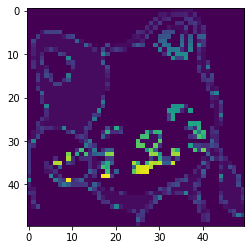

In [31]:
#Codigo para abrir y visualizar imágenes
img = Image.open('cat.png')
array=np.array(img)
imgplot = plt.imshow(array)
plt.show()

## 1. Interpolación bicubica

### 1.1  Obtener derivadas (30 puntos)

Implemente la función `derivativeValues` que reciba como input un arreglo con valores, el método de interpolación y si es que se considera el uso de  los puntos de chebyshev . La función debe retornar un arreglo de igual dimensión con los valores de las derivadas de los puntos obtenidas

Los métodos de interpolación serán representados por los siguientes valores

* Interpolación de lagrange: `'lagrange'`
* Diferencias divididas de Newton: `'newton'`
* Spline cubica: `'spline3'`


In [3]:
# Función proveniente del repositorio del curso.
# Calcula y retorna los puntos de Chebyshev
def Chebyshev_points(xmin,xmax,n):
    ns = np.arange(1,n+1)
    x = np.cos((2*ns-1)*np.pi/(2*n))
    #y = np.sin((2*ns-1)*np.pi/(2*n))
    return (xmin+xmax)/2 + (xmax-xmin)*x/2

# Función proveniente del repositorio del curso.
# Retorna los coeficientes de Diferencias Divididas de Newton
def Divided_Differences(x, y):
    dd = np.array([y])
    dd = dd.astype("int32")
    for i in range(len(x)-1):
        ddi = []
        for a in range(len(x)-i-1):
            ddi.append((dd[i][a+1]-dd[i][a])/(x[a+i+1]-x[a]))
        ddi = np.append(ddi,np.full((len(x)-len(ddi),),0.0))
        dd = np.append(dd,[ddi],axis=0)
        
    return np.array(dd)

# Función proveniente del repositorio del curso.
# Retorna un diccionario que contiene el polinomio interpolador
def Newton(x, y):
    # We calculate the divided differences and store them in a data structure
    dd = Divided_Differences(x,y)
    
    # Finally, we return a data structure with our interpolating polynomial
    D = {'M':'Newton',
         'P':dd[:,0],
         'x':x,
         'y':y}
    return D

def derivativeValues(values, method, cheb):
    """
    Parameters
    ----------
    values:	(int array) points values
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used

    Returns
    -------
    d:	(float array) derivative value of interpolated points

    """
    n = values.size
    d = -1
    if(cheb):
        xi = Chebyshev_points(1, n, n)
        xi.sort()
    else:
        xi = np.linspace(1, n, n)
        
    if(method == "lagrange"):
        pol = interpolate.lagrange(xi, values)
        polPrima = pol.deriv()
        polPrima = np.vectorize(polPrima)
        d = polPrima(xi)
    elif(method == "newton"):
        D = Newton(xi, values)
        coef = D['P']
        x = sp.symbols("x")
        expr = coef[0]
        expr_aux = 1
        for i in range(1, n): #Iteración para reconstruir el polinomio interpolador de Newton
            expr_aux *= (x-xi[i-1])   
            expr += coef[i]*expr_aux
        polPrima = sp.Derivative(expr)
        polPrima = polPrima.doit()
        polPrima = lambdify(x, polPrima)
        polPrima = np.vectorize(polPrima)
        d = polPrima(xi)
    elif(method == "spline3"):
        pol = interpolate.CubicSpline(xi, values)
        polPrima = pol.derivative()
        polPrima = np.vectorize(polPrima)
        d = polPrima(xi)
    else:
        pass
    return d


### 1.2 Interpolación de imagen (50 puntos)
Implemente la función `bicubicInterpolation` que reciba como input la matriz de la imagen y cuantos píxeles extra se quiere agregar entre los píxeles originales y el algoritmo de interpolación a utilizar. La función debe retornar la matriz con la imagen de dimensión nueva. Considere que se debe aplicar el método de interpolación en cada canal RGB por separado.

In [4]:


def derivarCanal(canal, interiorPixels, method, cheb, x = True):
    """
    Parameters
    ----------
    canal:	(nxn array) Uno de los canales RGB
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used
    x:	(boolean)	 Si la derivada se calcula a lo largo de la horizontal

    Returns
    -------
    derivada:	(nxn array) matriz con los valores de la derivada
    """
    
    n = canal.shape[0]
    derivada = np.zeros((n,n))
    canal_aux = np.copy(canal)
    if(not x):
        canal_aux = canal_aux.T # Se usa la traspuesta en caso de que se calcule la derivada en y
    flag = True
    for i in range(0,n):
        for j in range(1,n-1):
            values = np.array([canal_aux[i][j-1], canal_aux[i][j], canal_aux[i][j+1]])
            p1, p2, p3 = derivativeValues(values, method, cheb)
            if(j == 1):
                derivada[i][0] = p1
            elif(j == n-2):
                derivada[i][n-1] = p3
            derivada[i][j] = p2
    if(not x):
        derivada = derivada.T # Se retorna la traspuesta en caso de que se calcule la derivada en y
    return derivada


def bicubicInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    newImage:	(nxnx3 array) image array in RGB format

    """
    n = image.shape[0]
    matrizAux = image.reshape(n*n,3)
    R = matrizAux[:,0].reshape(n,n) # Se separan los canales en distintas matrices
    G = matrizAux[:,1].reshape(n,n)
    B = matrizAux[:,2].reshape(n,n)
    RGB = [R,G,B]
    
    
    new_R = np.zeros((n+interiorPixels*(n-1),n+interiorPixels*(n-1)))
    new_G = np.zeros((n+interiorPixels*(n-1),n+interiorPixels*(n-1))) # Se definen las nuevas matrices para cada canal
    new_B = np.zeros((n+interiorPixels*(n-1),n+interiorPixels*(n-1)))
    new_RGB = [new_R, new_G, new_B]
    cont = 0
    for newCanal in new_RGB:
        for i in range(n):
            for j in range(n):
                newCanal[i+i*interiorPixels][j+j*interiorPixels] = RGB[cont][i][j]
        cont += 1
    
    # Matriz inversa de A, para resolver el sistema de ecuaciones
    # y obtener los coeficientes de la superficie interpoladora
    A_inv = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
                     [-3,3,0,0,-2,-1,0,0,0,0,0,0,0,0,0,0],
                     [2,-2,0,0,1,1,0,0,0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
                     [0,0,0,0,0,0,0,0,-3,3,0,0,-2,-1,0,0],
                     [0,0,0,0,0,0,0,0,2,-2,0,0,1,1,0,0],
                     [-3,0,3,0,0,0,0,0,-2,0,-1,0,0,0,0,0],
                     [0,0,0,0,-3,0,3,0,0,0,0,0,-2,0,-1,0],
                     [9,-9,-9,9,6,3,-6,-3,6,-6,3,-3,4,2,2,1],
                     [-6,6,6,-6,-3,-3,3,3,-4,4,-2,2,-2,-2,-1,-1],
                     [2,0,-2,0,0,0,0,0,1,0,1,0,0,0,0,0],
                     [0,0,0,0,2,0,-2,0,0,0,0,0,1,0,1,0],
                     [-6,6,6,-6,-4,-2,4,2,-3,3,-3,3,-2,-1,-2,-1],
                     [4,-4,-4,4,2,2,-2,-2,2,-2,2,-2,1,1,1,1]])
    
    cont = 0
    for canal in RGB: # Iteración por cada canal RGB
        fx = derivarCanal(canal, interiorPixels, method, cheb, x = True)
        fy = derivarCanal(canal, interiorPixels, method, cheb, x = False) # Se calculan las derivadas
        fxy = derivarCanal(fy, interiorPixels, method, cheb, x = True)
        for i in range(n-1):
            for j in range(n-1):
                f = [canal[i][j], canal[i+1][j], canal[i][j+1], canal[i+1][j+1],
                     fx[i][j], fx[i+1][j], fx[i][j+1], fx[i+1][j+1],
                     fy[i][j], fy[i+1][j], fy[i][j+1], fy[i+1][j+1],
                     fxy[i][j], fxy[i+1][j], fxy[i][j+1], fxy[i+1][j+1]]
                alfa = A_inv.dot(f) # Se obtienen los coeficientes
                x,y = sp.symbols("x y")
                cont2 = 0
                expr = 0
                for k in range(4):
                    for l in range(4):
                        expr += alfa[cont2]*(x**l)*(y**k) # Se crea la superficie interpoladora
                        cont2 += 1
                p = lambdify([x,y], expr)
                eje = np.linspace(0,1,interiorPixels+2)
                for k in range(interiorPixels+2): # Iteraciones para rellenar los nuevos canales
                    for l in range(interiorPixels+2):
                        if((k == 0 and l == 0) or (k == 0 and l == interiorPixels+1) or (k == interiorPixels+1 and l == 0) or (k == interiorPixels+1 and l == interiorPixels+1)):
                            continue
                        new_RGB[cont][i+i*interiorPixels+k][j+j*interiorPixels+l] = p(eje[k], eje[l]) # PAPOPE
                        if(new_RGB[cont][i+i*interiorPixels+k][j+j*interiorPixels+l] > 255):
                            new_RGB[cont][i+i*interiorPixels+k][j+j*interiorPixels+l] = 255
                        elif(new_RGB[cont][i+i*interiorPixels+k][j+j*interiorPixels+l] < 0):
                            new_RGB[cont][i+i*interiorPixels+k][j+j*interiorPixels+l] = 0
        cont += 1
    newImage = np.zeros(((n+interiorPixels*(n-1))*(n+interiorPixels*(n-1)), 3))     
    newImage[:,0] = new_R.reshape((n+interiorPixels*(n-1))*(n+interiorPixels*(n-1)))
    newImage[:,1] = new_G.reshape((n+interiorPixels*(n-1))*(n+interiorPixels*(n-1))) # Se unen nuevamente los canales
    newImage[:,2] = new_B.reshape((n+interiorPixels*(n-1))*(n+interiorPixels*(n-1))) # en una sola matriz
    newImage = newImage.reshape(n+interiorPixels*(n-1), n+interiorPixels*(n-1), 3)
    newImage = newImage.astype('int32')
    return newImage

## 2. Evaluacion de algoritmos



### 2.1 Tiempo de ejecucion 
Implemente la funcion `timeInterpolation` que mida el tiempo de interpolacion de una imagen dado el algoritmo de interpolacion , en segundos.(5 puntos)

In [5]:
def timeInterpolation(image, interiorPixels, method,cheb):
    """
    Parameters
    ----------
    image:	(nxnx3 array) image array in RGB format
    interiorPixels:	(int)	interpolation method
    method:	(string)	interpolation method
    cheb:	(boolean)	if chebyshev points are used


    Returns
    -------
    tiempo:	(float) time in seconds

    """
    t1 = time.time()
    bicubicInterpolation(image, interiorPixels, method,cheb)
    t2 = time.time()
    tiempo = t2-t1
    return tiempo

***Pregunta: ¿Cual es el metodo que presenta mayor velocidad en general? (5 puntos)***

En general, el método de Lagrange presenta mayor velocidad, probando para distintas cantidades de pixeles interiores y variando en si se hace uso de puntos de Chebyshev o no.

### 2.2 Calculo de error
Implemente la funcion `errorInterpolation` la cual debe obtener el error de la imagen obtenida comparandola con una de referencia. El error debe ser calculado utilizando el indice SSIM (Structural similarity) (5 puntos)

In [6]:
def errorInterpolation(original,new):
    """
    Parameters
    ----------
    image:	(nxn array) original image array in RGB format
    new:	(nxn array) new image array in RGB format obtained from interpolation


    Returns
    -------
    error:	(float) difference between images 

    """
    error = 1 - ssim(original, new, multichannel = True, data_range = original.shape[0])
    return error

***Pregunta: ¿Cual metodo presenta menor error? (5 puntos)***

En general todos poseen casi el mismo error, sin embargo Lagrange en ciertos casos difiere en 1 unidad respecto a los demás métodos, siendo este menor.

# Consideraciones

* Solo trabajaremos con imagenes cuadradas
* En el caso que el valor interpolado de un punto sea mayor a 255 o menor a 0, este se trunca a 255 o 0 respectivamente
* Esta permitido el uso de sympy para calcular derivadas y para construir el polinomio interpolador 
* El calculo de error puede ser calculado utilizando la imagen en escala de grises [(ejemplo)](https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html)